## transform data

In [1]:
# old_data_dir = Path('/scratch/projects/023/01_data/synthetic/001')
# output_data_dir = Path('/scratch/projects/023/01_data/synthetic/001_radon')
# annotations_file = '/scratch/projects/023/01_data/synthetic/001/annotations.csv'

In [2]:
# new_annotations = []

# for i, row in tqdm(df.iterrows(), total=len(df)):
#     x = np.load(old_data_dir / row['filename'])
#     x[mask] = 0.
    
#     for i, rotation_angle in enumerate(np.random.uniform(*rotation_range, n_rotations)):
#         rotated = skimage.transform.rotate(x, rotation_angle)
#         radonized = skimage.transform.radon(rotated)
#         radon_resized = skimage.transform.resize(radonized, shape_out, anti_aliasing=True)
#         radon_resized -= radon_resized.min()
#         radon_resized /= radon_resized.max()
#         new_filename = Path(row['filename']).stem + f'_{i}.npy'
#         np.save(output_data_dir / new_filename, radon_resized)
#         entry = row.to_dict()
#         entry['direction'] = rotation_angle
#         entry['filename'] = new_filename
#         new_annotations.append(entry)
# new_annotations = pd.DataFrame(new_annotations)
# new_annotations.to_csv(output_data_dir / 'annotations.csv', index=False)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

import torch
import torchvision
import cv2
from torchvision.transforms.functional import rotate, center_crop, resize
from albumentations import ElasticTransform, Compose, Blur
from albumentations.augmentations.geometric import functional as albu_geom
from albumentations.pytorch import ToTensorV2
import albumentations as A
import pytorch_lightning as pl
import timm
from hydra.utils import instantiate
from timm.scheduler import CosineLRScheduler

/home/jupyter/.local/lib/python3.10/site-packages/neptune/internal/backends/hosted_client.py:51: NeptuneDeprecationWarning: The 'neptune-client' package has been deprecated and will be removed in the future. Install the 'neptune' package instead. For more, see https://docs.neptune.ai/setup/upgrading/
  from neptune.version import version as neptune_client_version
/home/jupyter/.local/lib/python3.10/site-packages/pytorch_lightning/loggers/neptune.py:51: NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.
  import neptune.new as neptune


In [4]:
from src import transforms, models

/scratch/projects/023/06_periodicity/src/models.py:180: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if 'regularization' is losses:


## data pipe

In [5]:
# existing_dirs = []
# for _, row in tqdm(anns.iterrows(), total=len(anns)):
#     subdir_name = row.model
#     subdir = data_dir / subdir_name
#     if not subdir_name in existing_dirs:
#         subdir.mkdir(exist_ok=True)
#         existing_dirs.append(subdir_name)
#     (data_dir / row.filename).rename(subdir / row.filename)

In [6]:
data_dir = Path('/scratch/projects/023/01_data/synthetic/001_radon')
annotations_file = data_dir / 'annotations.csv'

In [7]:
anns = pd.read_csv(annotations_file)
anns = anns.loc[anns['sampling_t']==120]
anns.sample(10)

# anns['model'].value_counts()

,filename,model,sampling_t,span,value_min,white_fraction,period,img_filename,idx,direction
589005,strips_36812_001_model-23_120_13.npy,001_model-23,120,0.153283,0.169919,0.479474,9.906873,strips_36812_001_model-23_120.png,36812,-19.674892
531167,strips_33197_001_model-23_120_15.npy,001_model-23,120,0.213943,0.169324,0.656512,18.858015,strips_33197_001_model-23_120.png,33197,-10.493788
639162,strips_39947_001_model-23_120_10.npy,001_model-23,120,0.209998,0.166107,0.490885,12.960630,strips_39947_001_model-23_120.png,39947,-35.205157
573346,strips_35834_001_model-23_120_2.npy,001_model-23,120,0.152406,0.123120,0.357449,15.982087,strips_35834_001_model-23_120.png,35834,-26.929715
498115,strips_31132_001_model-23_120_3.npy,001_model-23,120,0.161085,0.177549,0.571599,16.338244,strips_31132_001_model-23_120.png,31132,65.464578
621359,strips_38834_001_model-23_120_15.npy,001_model-23,120,0.170638,0.170802,0.379136,31.556410,strips_38834_001_model-23_120.png,38834,-4.723972
551801,strips_34487_001_model-23_120_9.npy,001_model-23,120,0.123926,0.158990,0.369051,14.751947,strips_34487_001_model-23_120.png,34487,25.573227
1180923,strips_73807_005_model-11_120_11.npy,005_model-11,120,0.172647,0.151923,0.261100,28.023313,strips_73807_005_model-11_120.png,73807,25.495964
1266769,strips_79173_005_model-11_120_1.npy,005_model-11,120,0.165386,0.148239,0.657769,9.640596,strips_79173_005_model-11_120.png,79173,43.812260
507645,strips_31727_001_model-23_120_13.npy,001_model-23,120,0.281587,0.128759,0.436718,23.560025,strips_31727_001_model-23_120.png,31727,-9.479043


In [8]:
class StripsDatasetNumpy(torch.utils.data.Dataset):
    def __init__(self, annotations, data_root='', transforms=[]):
        if isinstance(annotations, Path) or isinstance(annotations, str):
            self.annotations = pd.read_csv(annotations)
        else:
            self.annotations = annotations
        self.data_root = Path(data_root)
        self.transforms = transforms
    
    def __getitem__(self, idx):
        row = self.annotations.iloc[idx]
        image_data = {
            'image':np.load(self.data_root / row.model / row['filename']),
            'period': row['period'],
            'white_fraction': row['white_fraction'],
            'direction': row.get('direction', 0.)
        }

        for transform in self.transforms:
            image_data = transform(**image_data)
        
        return {
            'image': image_data['image'], 
            'period':  torch.tensor(image_data['period'], dtype=torch.float32), 
            'white_fraction':  torch.tensor(image_data['white_fraction'], dtype=torch.float32),
            'direction': torch.tensor(image_data['direction'], dtype=torch.float32)
            }

    def __len__(self):
        return len(self.annotations)

{'image': array([[0.01052537, 0.01264006, 0.01422994, ..., 0.00291828, 0.00268082,
        0.00220837],
       [0.01052537, 0.01264006, 0.01422994, ..., 0.00291828, 0.00268082,
        0.00220837],
       [0.0291073 , 0.0338479 , 0.03750857, ..., 0.01079587, 0.01009607,
        0.00872451],
       ...,
       [0.09681785, 0.10285603, 0.10711957, ..., 0.10726984, 0.10933012,
        0.11018687],
       [0.03911294, 0.04361727, 0.04681711, ..., 0.07063167, 0.0684135 ,
        0.06519723],
       [0.03911294, 0.04361727, 0.04681711, ..., 0.07063167, 0.0684135 ,
        0.06519723]], dtype=float32), 'period': tensor(19.9094), 'white_fraction': tensor(0.5733), 'direction': tensor(-34.5284)}


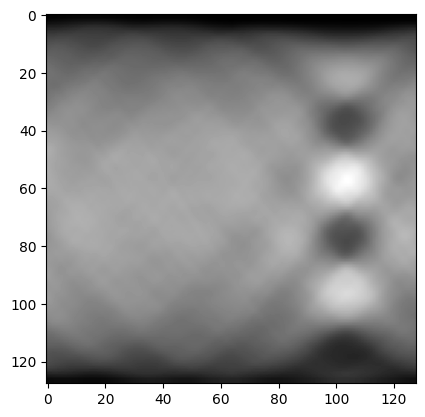

In [9]:
ds_raw = StripsDatasetNumpy(annotations_file, data_dir)
image_data = ds_raw[200]
plt.imshow(image_data['image'], vmin=0, vmax=1, cmap='gray')
print(image_data)

In [10]:
transforms_config = {
    'blur_train': dict(blur_limit=(3,7), sigma_limit=(0.1, 0.5), p=0.8),
    'blur_test': dict(blur_limit=(5,5), sigma_limit=(0.3, 0.3), p=1),
    'normalization': None #{'mean': 0., 'std': 1.},
}

In [11]:
normalization = transforms_config['normalization']

train_transforms = []

if transforms_config.get('blur_train') is not None:
    train_transforms.append(A.GaussianBlur(**transforms_config['blur_train']))

test_transforms = []

if transforms_config.get('blur_test') is not None:
    test_transforms.append(A.GaussianBlur(**transforms_config['blur_test']))
if transforms_config['normalization'] is not None:
    train_transforms.append(A.Normalize(**normalization))
    test_transforms.append(A.Normalize(**normalization))


train_transforms.append(ToTensorV2())
test_transforms.append(ToTensorV2())

ds = StripsDatasetNumpy(
    annotations_file, 
    data_dir,
    transforms= train_transforms
    )

# # https://albumentations.ai/docs/api_reference/augmentations/transforms/
# A.CLAHE
# A.Equalize
# A.PixelDropout
# A.Superpixels


In [12]:
# input = ds_raw[idx] #{'image_path': str(anns.iloc[idx]['img_path'], 'period': annotations.iloc[idx]['period'], 'direction': annotations.iloc[idx]['direction']-90}

torch.Size([1, 128, 128]) torch.float32 tensor(1.) tensor(2.0922e-09)


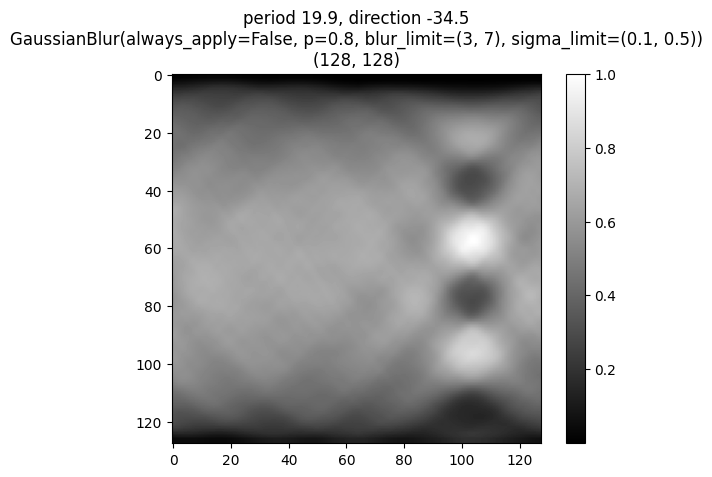

In [13]:
idx = 200
input = ds_raw[idx] #{'image_path': str(anns.iloc[idx]['img_path'], 'period': annotations.iloc[idx]['period'], 'direction': annotations.iloc[idx]['direction']-90}

# [ReadImage(mode=cv2.IMREAD_GRAYSCALE)] + 
for transform in train_transforms:
  input = transform(**input)
  img = input['image']
  if isinstance(img, torch.Tensor):
    print(img.shape, img.dtype, img.max(), img.min())
  else:
    plt.figure()
    plt.imshow(input['image'], cmap='gray')
    plt.title(f'period {input["period"]:0.1f}, direction {input["direction"]:0.1f}\n{transform}\n{img.shape}')
    plt.colorbar()

In [14]:
repr(train_transforms)

'[GaussianBlur(always_apply=False, p=0.8, blur_limit=(3, 7), sigma_limit=(0.1, 0.5)), ToTensorV2(always_apply=True, p=1.0, transpose_mask=False)]'

## Model

In [15]:
from pytorch_lightning.loggers import TensorBoardLogger


In [16]:
len(anns)

326400

In [17]:
num_workers = 0
batch_size = 512

# print(len(anns))
anns_sample = anns #.sample(frac=1) #anns.sample(15000) #shuffle 

train_size = 300_000 #1_200_000
val_size = 20_000

ds_train = StripsDatasetNumpy(anns_sample.iloc[:train_size].sample(frac=1).reindex(), data_root=data_dir, transforms=train_transforms)
ds_val = StripsDatasetNumpy(anns_sample.iloc[train_size:train_size+val_size].reindex(), data_root=data_dir, transforms=test_transforms)


dl_train = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
dl_val = torch.utils.data.DataLoader(ds_val, batch_size=batch_size, num_workers=num_workers, pin_memory=True)


In [18]:
# %timeit next(iter(dl_train))

In [19]:
# for batch in dl_train:
#     break

In [20]:
# batch.keys()

In [21]:
# batch['direction']

In [22]:
num_epochs = 50

# use_neptune_logger = False
logging_dir = 'logs_radon_diffusion_byangle'

loggers = [TensorBoardLogger(save_dir='.', name=logging_dir, default_hp_metric=False)] 
# if use_neptune_logger:
#     neptune_logger = NeptuneLogger(
#         api_key="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkYjhjYzFiYi02OGEyLTRhYzMtOWMzMS1kMDc1OGFiMzgwMjcifQ==",
#         project='UWCenter4ML/023-strips-synthetic',
#         tags=[f'size_{len(anns_sample)}', 'direction', 'period', 'radon'],
#         log_model_checkpoints=True,
#     )
#     loggers.append(neptune_logger)    

In [23]:
torch.cuda.is_available()

True

In [24]:
trainer = pl.Trainer(
    # default_root_dir=os.path.join(CHECKPOINT_PATH, save_name),  # Where to save models
    # We run on a single GPU (if possible)
    accelerator='gpu',
    precision='16-mixed',
    # How many epochs to train for if no patience is set
    max_epochs=num_epochs,
    log_every_n_steps=1,
    val_check_interval=0.05,
    # limit_train_batches=20,
    gradient_clip_val=1,
    logger = loggers,
    callbacks=[
        pl.callbacks.ModelCheckpoint(
            save_weights_only=True, mode="min", monitor="val_loss", save_top_k=3, filename='{epoch}-{val_loss:.2f}'
        ),  # Save the best checkpoint based on the maximum val_acc recorded. Saves only weights and not optimizer
        pl.callbacks.ModelCheckpoint(
            save_weights_only=True, every_n_epochs=5, filename='{epoch}-{val_loss:.2f}'
        ),
        pl.callbacks.LearningRateMonitor("epoch"),
        pl.callbacks.StochasticWeightAveraging(swa_lrs=1e-2),
        # pl.callbacks.DeviceStatsMonitor(cpu_stats=True), # statystyki procesora itp - bardzo duzo
    ],  # Log learning rate every epoch
    # progress_bar_refresh_rate=1,
    profiler=pl.profilers.PyTorchProfiler(filename="profiler_output"), #"simple"
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [26]:
model_name = 'mobilenetv3_small_050' # 'resnet18', 'mobilenetv3_small_050' (fast), 'tinynet_e' (fast), 'lcnet_050' (fast), 'resnet10t' (fast), 'resnet18', 'convnext_atto', 'cs3darknet_focus_s'
learning_rate = 0.001
optimizer_hparams = dict()
# lr_hparams=dict(_target_='torch.optim.lr_scheduler.CosineAnnealingLR', T_max=num_epochs, eta_min=0.0001) #dict(milestones=[170, 250], gamma=0.25),
lr_hparams=dict(_target_='__main__.CosineLRScheduler', t_initial=5, warmup_t=2., warmup_lr_init=1e-5, k_decay=1, cycle_mul=1, lr_min=1e-5, cycle_limit=5, cycle_decay=0.5)
loss_hparams=dict(rotation_weight=100., white_frac_weight=1000., regularization_weight=0.001)
angle_hparams=dict(angle_range=180., angle_min=-90.)
regularizer_hparams = dict(_target_='__main__.models.AngleRegularizerLog')



In [27]:
torch.set_float32_matmul_precision('medium')

In [28]:
pl_model = models.StripsModel(
    lr = learning_rate,
    optimizer_hparams = optimizer_hparams,
    model_name = model_name,
    lr_hparams = lr_hparams,
    loss_hparams = loss_hparams,
    angle_hparams=angle_hparams,
    regularizer_hparams=regularizer_hparams
)

In [29]:
# tuner = pl.tuner.Tuner(trainer)

# # finds learning rate automatically
# # sets hparams.lr or hparams.learning_rate to that learning rate
# tuner.lr_find(pl_model, dl_train, dl_val) # , attr_name='hparams.optimizer_hparams.lr'

In [30]:
# for angle_ndim in [1, 2]:
#     for angle_range in [180., 360.]:
#         angle_hparams = dict(ndim=angle_ndim, angle_range=angle_range)


# # (neptune) log hyper-parameters
# if use_neptune_logger:
#     neptune_logger.log_hyperparams(params={
#         **pl_model.hparams,
#         'transforms_config': transforms_config,
#         'data_train_transform': repr(train_transforms),
#         'data_test_transform': repr(test_transforms)
#         })
# try:
trainer.fit(pl_model, dl_train, dl_val)
# except Exception as e:
#     print(e)
# finally:
#     if use_neptune_logger:
#         neptune_logger.run.stop()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


MisconfigurationException: The provided lr scheduler `CosineLRScheduler` doesn't follow PyTorch's LRScheduler API. You should override the `LightningModule.lr_scheduler_step` hook with your own logic if you are using a custom LR scheduler.

In [ ]:
preds, losses, mae = pl_model.cpu().process_batch_supervised(next(iter(dl_train)))

In [ ]:
'regularization' in losses

In [ ]:
losses

In [ ]:
ds_test = StripsDatasetNumpy(anns_sample.iloc[train_size+val_size:train_size+2*val_size].reindex(), data_root=data_dir, transforms=test_transforms)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=batch_size, num_workers=num_workers, pin_memory=True)

In [ ]:
trainer.test(ckpt_path="best", dataloaders=dl_test)


In [ ]:
# torch.set_float32_matmul_precision('medium')

In [ ]:
# neptune_logger.run.stop()

In [ ]:
# torch._C._cuda_init()

## Validate

In [ ]:
# from skimage.transform import rotate, radon

In [ ]:
# checkpoint_path = 'lightning_logs/version_37/checkpoints/epoch=46-step=35250.ckpt'
# pl_model.load_from_checkpoint(checkpoint_path)

# disable randomness, dropout, etc...
pl_model.eval().cuda();

In [ ]:
test_batch = next(iter(dl_test))

In [ ]:
with torch.inference_mode():
    preds_direction, preds_period, preds_white_frac = pl_model(test_batch['image'].cuda())

In [ ]:
preds_direction.min(), preds_direction.max(), test_batch['direction'].min(), test_batch['direction'].max()

In [ ]:
plt.scatter((test_batch['direction'])%180, preds_direction.cpu())
# plt.plot()

In [ ]:
plt.scatter(test_batch['period'], preds_period.cpu())


In [ ]:
plt.scatter(test_batch['white_fraction'], preds_white_frac.cpu())


In [ ]:
# inference_transform = A.Compose([
#     # A.CenterCrop(64, 64),
#     A.GaussianBlur(always_apply=True, blur_limit=(5, 5), sigma_limit=(0.3, 0.3)),
#     A.CLAHE(always_apply=True, clip_limit=(1, 4.0), tile_grid_size=(8, 8)),
#     A.Normalize(**normalization),
#     ToTensorV2()
# ])

In [ ]:
import skimage
from tqdm.notebook import tqdm

In [ ]:
real_images_paths = list(Path('/scratch/projects/023/01_data/crops/C_100/MB_010_20221219_frompretrained').glob('*png'))
# real_images_paths = list(Path('/scratch/projects/023/01_data/synthetic/001').glob('*png'))

In [ ]:
output_dir = Path('predictions/radon/003_mobilenet')
output_dir.mkdir(parents=True)

In [ ]:
idx = 0
for img_path in tqdm(real_images_paths[:300]):
    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE) / 255
    
    X, Y = np.meshgrid(np.arange(img.shape[0])-0.5, np.arange(img.shape[0])-0.5)
    r = img.shape[0]/2
    mask = ((X-r)**2 +(Y-r)**2) >= r**2
    masked = img.copy()
    masked[mask] = 0.
    
    radonized = skimage.transform.radon(masked)
    radonized = skimage.transform.resize(radonized, (128,128), anti_aliasing=True)
    radonized -= radonized.min()
    radonized /= radonized.max()
    
    with torch.inference_mode():
        preds_direction, preds_period, preds_white_frac = pl_model(torch.tensor(radonized, dtype=torch.float32).unsqueeze(0).unsqueeze(0).cuda())
    
    angle = preds_direction[0].item()
    period = preds_period[0].item()*img.shape[0]/64
    white_fraction = preds_white_frac[0].item()
    
    fig = plt.figure()
    plt.imshow(skimage.transform.rotate(img, -angle), vmin=0, vmax=1, cmap='gray')
    plt.title(f'period: {period:0.1f}, white fraction: {white_fraction*100:0.0f}%')
    plt.grid(True, axis='x')
    for x in np.arange(0, img.shape[0], period):
        plt.axvline(x, c='red')
    fig.savefig(output_dir / f'{Path(img_path).stem}_rotated.png')
    plt.close('all')

#         radon_resized = skimage.transform.resize(radonized, shape_out, anti_aliasing=True)
 # x = np.load(old_data_dir / row['filename'])
#     x[mask] = 0.
    
#     for i, rotation_angle in enumerate(np.random.uniform(*rotation_range, n_rotations)):
#         rotated = skimage.transform.rotate(x, rotation_angle)
#         radonized = skimage.transform.radon(rotated)
#         radon_resized = skimage.transform.resize(radonized, shape_out, anti_aliasing=True)
#         radon_resized -= radon_resized.min()
#         radon_resized /= radon_resized.max()

# with torch.inference_mode():
#     preds_direction, preds_period, preds_white_frac = pl_model(inference_transform(image=img)['image'].unsqueeze(0))

# plt.imshow(rotate(img, preds_direction[0]+90), cmap='gray', vmin=0, vmax=1)
# plt.title(f'period {preds_period[0]:0.1f}');
# for y in np.arange(0, 64, preds_period[0]):
#     plt.axhline(y,c='r')


In [ ]:
angle = preds_direction[0].item()
print(angle)

In [ ]:
plt.imshow(skimage.transform.rotate(img, -angle))

In [ ]:
img_batch = torch.stack([
    inference_transform(image=img)['image'],
    inference_transform(image=img[::-1])['image'],
    inference_transform(image=img[:,::-1])['image'],
    inference_transform(image=img[::-1,::-1])['image']
])

with torch.inference_mode():
    preds_direction, preds_period, preds_white_frac = pl_model(img_batch)

pred_direction = (preds_direction.numpy() *  np.array([1, -1, -1, 1])).mean()
plt.imshow(rotate(img, pred_direction+90), cmap='gray', vmin=0, vmax=1)


In [ ]:
plt.imshow(img_batch[0,0].numpy(), cmap='gray')

In [ ]:
preds_direction

In [ ]:
preds_period

In [ ]:
rotate(img, -15).min()

In [ ]:
plt.imshow(rotate(img, -20), cmap='gray', vmin=0, vmax=1)
plt.axhline(30)
plt.axhline(56)
plt.axhline(82)

In [ ]:
torch.rand(10).reshape((2,5))

In [ ]:
from torch import nn

In [ ]:
class F1(nn.Module):
    def __init__(self, n_freqs, freq_min, freq_max):
        super().__init__()
        self.a = nn.Parameter(torch.tensor(0.))
        self.b = nn.Parameter(torch.tensor(0.))
        self.freqs = nn.Parameter((freq_min + torch.rand(n_freqs)* (freq_max-freq_min)).reshape(1, -1))
        self.phi = nn.Parameter(torch.rand(n_freqs).reshape(1, -1))
        self.C = nn.Parameter(torch.tensor(0.))
    def forward(self, x, y):
        t = self.a * x + self.b *y # b, 1
        v = torch.sin(2*torch.pi*(t*self.freqs + self.phi) ) # b, self.n_freqs
        return self.C + torch.sum(v, axis=1) # b
        

In [ ]:
f1 = F1(20, 1/50, 1/5)

In [ ]:
x = torch.rand(10).reshape(-1,1)
y = torch.rand(10).reshape(-1,1)

In [ ]:
f1(x, y).shape

In [ ]:
plt.imshow(img)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA()

In [ ]:
x, y = np.meshgrid(np.arange